In [168]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
from rdkit import Chem
from rdkit.Chem import Draw
import matplotlib.pyplot as plt
from rdkit.Chem import rdmolops
from morfeus import BuriedVolume
from rdkit.Chem import rdMolTransforms
from rdkit.Chem import rdDetermineBonds

In [34]:
METAL_ATOMS = ["Ru", "Rh", "Pd"]

In [147]:
class NoMetalException(Exception):
    pass

class NoDiphosphaneException(Exception):
    pass

class bcolors:
    HEADER = '\033[95m'
    OKBLUE = '\033[94m'
    OKCYAN = '\033[96m'
    OKGREEN = '\033[92m'
    WARNING = '\033[93m'
    FAIL = '\033[91m'
    ENDC = '\033[0m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'

In [86]:
def extract_complex(mol):
    fragments = rdmolops.GetMolFrags(mol, asMols=True, sanitizeFrags=False)
    for frag in fragments:
        metal = [atom for atom in frag.GetAtoms() if atom.GetSymbol() in METAL_ATOMS]
        if len(metal) > 0:
            phosphorus_neighbors = [n for n in metal[0].GetNeighbors() if n.GetSymbol() == 'P']
            if len(phosphorus_neighbors) >= 2:
                return frag
    return None

In [144]:
def remove_non_phosphorus_ligands(mol):
    # Create editable molecule
    no_ancillary = Chem.RWMol(mol)

    # Find metal atom
    metal = None
    for atom in no_ancillary.GetAtoms():
        if atom.GetSymbol() in METAL_ATOMS:
            metal = atom
            break

    if not metal:
        raise ValueError("No metal atom found")

    # Get all atoms directly bound to metal
    metal_neighbors = [x for x in metal.GetNeighbors()]

    # Find phosphorus atoms bound to metal
    p_atoms = [x for x in metal_neighbors if x.GetSymbol() == 'P']

    if not p_atoms:
        raise ValueError("No phosphorus ligands found")

    # Identify all atoms in non-P ligands bound to metal
    atoms_to_remove = set()

    for neighbor in metal_neighbors:
        if neighbor.GetSymbol() != 'P':
            # Perform BFS to find all atoms in this ligand
            visited = set()
            stack = [neighbor]
            while stack:
                atom = stack.pop()
                if atom.GetIdx() in visited:
                    continue
                visited.add(atom.GetIdx())
                # Add all neighbors except metal
                for nbr in atom.GetNeighbors():
                    if nbr.GetIdx() != metal.GetIdx():
                        stack.append(nbr)
            atoms_to_remove.update(visited)

    # Remove atoms in reverse order to maintain correct indices
    for atom_idx in sorted(atoms_to_remove, reverse=True):
        no_ancillary.RemoveAtom(atom_idx)

    return no_ancillary.GetMol()

In [196]:
ligand_list = []
for type in os.listdir(""):
    type_dir = os.listdir("chapter_1/" + type)
    for i, struc in enumerate(type_dir):
        struc_split = struc.split(".")
        struc_name = struc_split[0]
        struc_type = type.upper()
        if struc_name in [l["Name"] for l in ligand_list]:
            continue
        if len(struc_name) > 6:
            print(f"{bcolors.FAIL}SKIPPED {type.upper()} ({i}/{len(type_dir)}): {struc_name}{bcolors.ENDC}")
            continue
        m = Chem.MolFromXYZFile(f"chapter_1/{type}/{struc}")
        rdDetermineBonds.DetermineConnectivity(m)

        mol = extract_complex(m)
        metal = [a for a in mol.GetAtoms() if a.GetSymbol() in METAL_ATOMS][0]
        phosphorus_list = sorted([a for a in mol.GetAtoms() if a.GetSymbol() == "P"], key=lambda x: x.GetIdx())
        p1, p2 = phosphorus_list[0], phosphorus_list[1]
        p1_m_dist = rdMolTransforms.GetBondLength(mol.GetConformer(), p1.GetIdx(), metal.GetIdx())
        p2_m_dist = rdMolTransforms.GetBondLength(mol.GetConformer(), p2.GetIdx(), metal.GetIdx())
        bite_angle = rdMolTransforms.GetAngleDeg(mol.GetConformer(), p1.GetIdx(), metal.GetIdx(), p2.GetIdx())
        p_m_dist_avg = np.average([p1_m_dist, p2_m_dist])

        no_ancillary = remove_non_phosphorus_ligands(mol)

        atoms = no_ancillary.GetAtoms()
        elements = [a.GetSymbol() for a in atoms]
        try:
            metal_index = [a for a in no_ancillary.GetAtoms() if a.GetSymbol() in METAL_ATOMS][0].GetIdx() + 1
            phosphorus_list = sorted([a for a in no_ancillary.GetAtoms() if a.GetSymbol() == "P"], key=lambda x: x.GetIdx())
            p1_idx, p2_idx = phosphorus_list[0].GetIdx() + 1, phosphorus_list[1].GetIdx() + 1
        except IndexError:
            print(f"{bcolors.FAIL}ERROR for {type.upper()} ({i}/{len(type_dir)}): {struc_name}{bcolors.ENDC}")
            continue
        conformer = no_ancillary.GetConformer()
        coordinates = [np.array([coord.x, coord.y, coord.z]) for coord in
                       (conformer.GetAtomPosition(a.GetIdx()) for a in atoms)]
        excluded_atoms = [metal_index]
        bv = BuriedVolume(
            elements=elements,
            coordinates=coordinates,
            metal_index=metal_index,
            excluded_atoms=excluded_atoms,
            include_hs=True,
            radius=3.5,
            z_axis_atoms=[p1_idx, p2_idx],
            xz_plane_atoms=[p2_idx],
        )

        ligand_list.append({"Name": struc_name, "Type": struc_type, "%Vbur": bv.fraction_buried_volume, "Bite angle": bite_angle, "P1–M (Å)": p1_m_dist, "P2–M (Å)": p2_m_dist, "Avg. P–M (Å)": p_m_dist_avg, "Metal center": metal.GetSymbol()})

        print(f"{struc_type} ({i}/{len(type_dir)}): {struc_name}")

PC1P (0/167): ACIVIR
PC1P (1/167): AJINAK
PC1P (2/167): AJINEO
PC1P (3/167): AJINIS
PC1P (4/167): AKEGEC
PC1P (5/167): AKEGOM
PC1P (6/167): AKEHAZ
PC1P (7/167): ALECAV
PC1P (8/167): AVEDIO
PC1P (9/167): AVEDUA
PC1P (10/167): AVEFEM
PC1P (11/167): AVEFIQ
PC1P (12/167): AVEFOW
PC1P (13/167): AXENOH
PC1P (14/167): BADZIQ
PC1P (15/167): BASNOB
PC1P (16/167): BASPAP
PC1P (17/167): BEBZOX
PC1P (18/167): BEWPEZ
PC1P (19/167): BICLEH
PC1P (20/167): BIJPEP
PC1P (21/167): CENVEY
PC1P (22/167): CENVOI
PC1P (23/167): CIFREQ
PC1P (24/167): DAGVAI
PC1P (25/167): DARPUK
PC1P (26/167): DIYLED
PC1P (27/167): DOVPAF
SKIPPED PC1P (28/167): DOVPAF01
PC1P (29/167): DPMCPD
SKIPPED PC1P (30/167): DPMCPD01
SKIPPED PC1P (31/167): DPMPDS10
PC1P (32/167): EJUYUE
PC1P (33/167): FAJJOP
PC1P (34/167): FERVUT
PC1P (35/167): FUNGAW
PC1P (36/167): GALYIB
PC1P (37/167): GIFXEZ
PC1P (38/167): GIFXOJ
PC1P (39/167): GUZTIE
PC1P (40/167): HACVIQ
PC1P (41/167): HEFLOW
PC1P (42/167): HIPZAH
PC1P (43/167): HIQNIF
PC1P (44/167

In [200]:
df = pd.DataFrame(ligand_list)
df

,Name,Type,%Vbur,Bite angle,P1–M (Å),P2–M (Å),Avg. P–M (Å),Metal center
0,ACIVIR,PC1P,0.472728,71.710677,2.249206,2.252672,2.250939,Pd
1,AJINAK,PC1P,0.509726,72.640492,2.222619,2.237192,2.229905,Rh
2,AJINEO,PC1P,0.527290,72.834585,2.261114,2.231257,2.246185,Rh
3,AJINIS,PC1P,0.527930,72.990300,2.297025,2.326494,2.311760,Rh
4,AKEGEC,PC1P,0.425393,71.522400,2.281327,2.294107,2.287717,Ru
...,...,...,...,...,...,...,...,...
1641,HUFNUU,POP,0.464103,69.353947,2.208475,2.209893,2.209184,Pd
1642,KAQCUB,POP,0.395301,67.899705,2.250828,2.243718,2.247273,Ru
1643,RANTAE,POP,0.444314,68.699112,2.248628,2.228830,2.238729,Rh
1644,YIVPUQ,PSP,0.432474,75.841595,2.286820,2.277417,2.282119,Ru


In [211]:
df.to_csv("chapter_1/chapter_1.csv", index=False)

In [222]:
df = pd.read_csv("chapter_1.csv")

In [230]:
def create_3d_scatter(df, ax, x, y, z, xlabel, ylabel, zlabel, color_row, color_map, text=False):
    for i, row in df.iterrows():
        ax.scatter(
            row[x], row[y], row[z],
            color=color_map[row[color_row]],
            s=100,  # Marker size
            edgecolor='black',  # Add edge to markers
            linewidth=0.6
        )
        if text:
            ax.text(
                row[x], row[y], row[z] + 0.01,
                s= row["Name"],
                fontsize=12,
                color='black',
                ha='center',
                va='bottom'
            )

    # Set labels
    ax.set_xlabel(xlabel, fontsize=14, labelpad=10)
    ax.set_ylabel(ylabel, fontsize=14, labelpad=10)
    ax.set_zlabel(zlabel, fontsize=14, labelpad=10)

    # Reduce empty space by adjusting axis limits
    ax.set_xlim(df[x].min() - 1, df[x].max() + 1)  # Add small margin
    ax.set_ylim(df[y].min(), df[y].max())  # Add small margin
    ax.set_zlim(df[z].min(), df[z].max())  # Add small margin

    ax.spines['left'].set_color('black')
    ax.spines['bottom'].set_color('black')
    ax.grid(True, which="both", linestyle='--', linewidth=0.5)

def create_2d_scatter(df, ax, x, y, xlabel, ylabel, color_row, color_map, label_offset = 0, text=False):
    for i, row in df.iterrows():
        ax.scatter(
            row[x], row[y],
            color=color_map[row[color_row]],
            s=120,  # Marker size
            edgecolor='black',  # Add edge to markers
            linewidth=0.6
        )
        if text:
            ax.text(
                row[x], row[y] + label_offset, row["Name"],
                fontsize=12,
                color='black',
                ha='center',
                va='bottom'
            )
    ax.set_xlabel(xlabel, fontsize=20, labelpad=20)
    ax.set_ylabel(ylabel, fontsize=20, labelpad=20)

    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.spines['left'].set_color('black')
    ax.spines['bottom'].set_color('black')
    ax.grid(True, which="both", linestyle='--', linewidth=0.5)
    sns.despine(ax=ax)  # Removes top and right spines

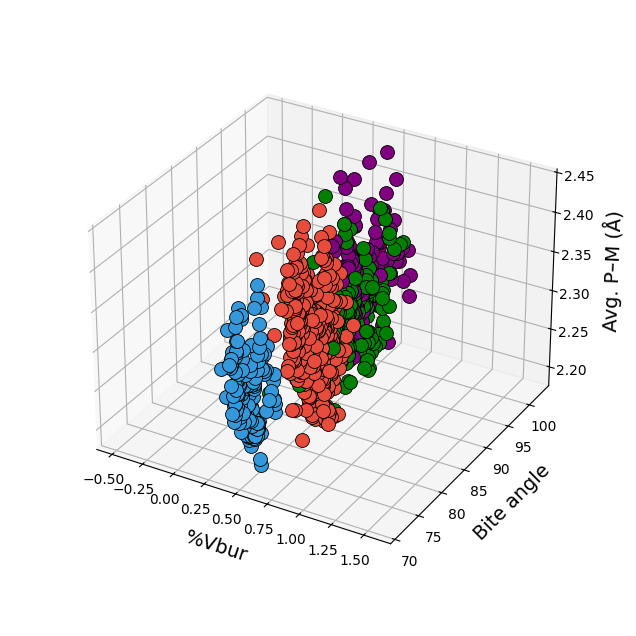

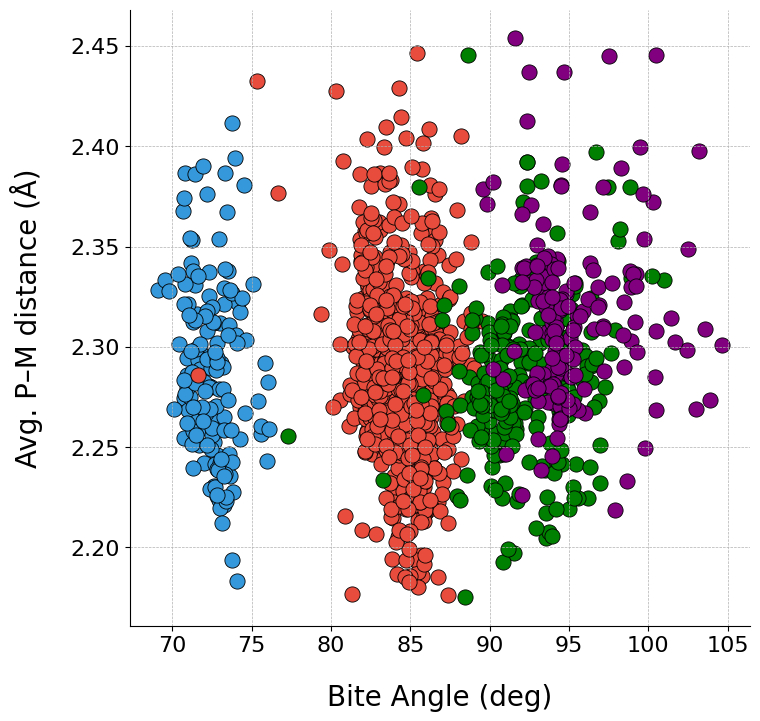

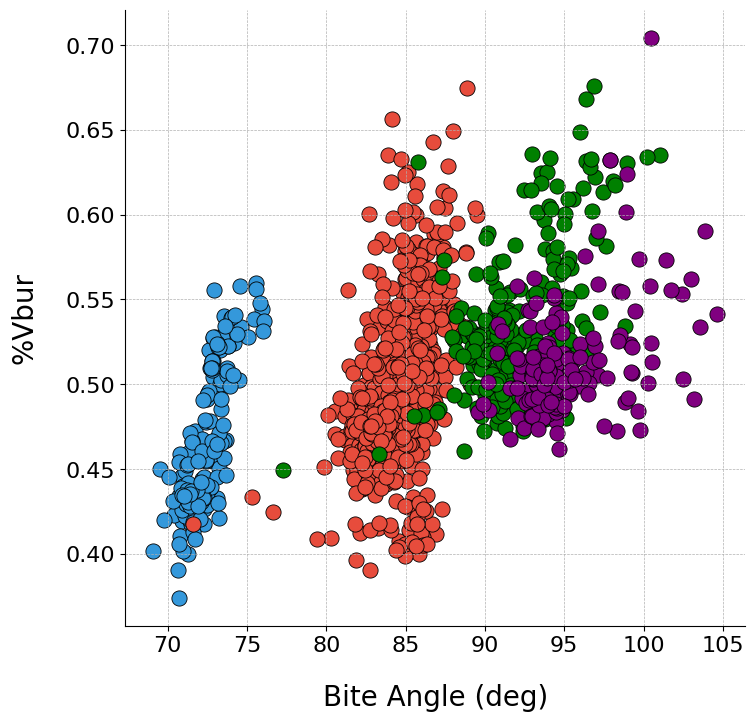

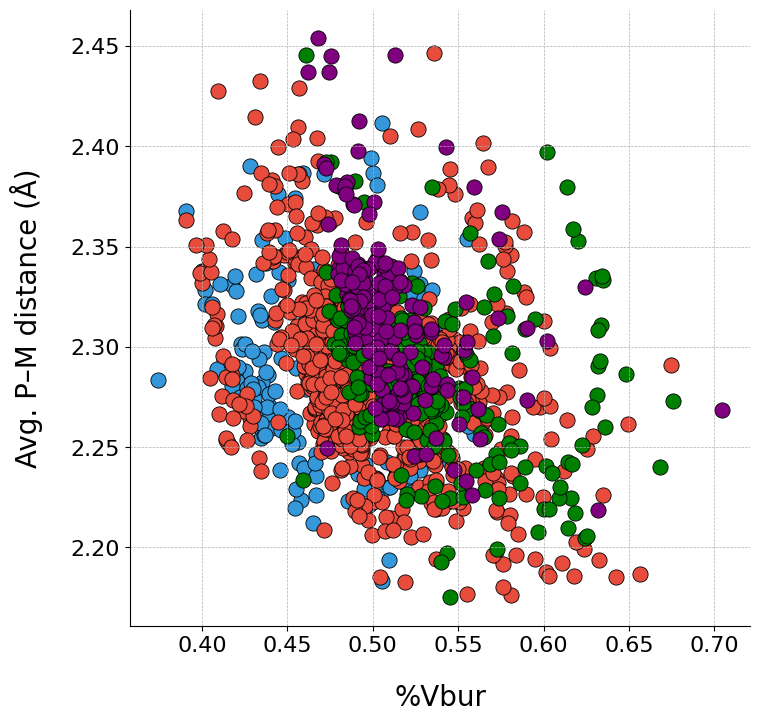

In [226]:
bridge_df = df[df["Type"].isin(['PC1P', 'PC2P', 'PC3P', 'PC4P'])]
color_map = {
    'PC1P': '#3498DB',
    'PC2P': '#E74C3C',
    'PC3P': "green",
    "PC4P": "purple"
}

fig = plt.figure(figsize=(10, 8), facecolor="white")

ax1 = fig.add_subplot(111, projection='3d')
create_3d_scatter(bridge_df, ax1, '%Vbur', 'Bite angle', 'Avg. P–M (Å)', '%Vbur', 'Bite angle', 'Avg. P–M (Å)', "Type", color_map)
ax1.set_box_aspect(None, zoom=0.85)
plt.show()

fig = plt.figure(figsize=(8, 8), facecolor="white")
ax2 = fig.add_subplot(111)
create_2d_scatter(bridge_df, ax2, 'Bite angle', 'Avg. P–M (Å)', 'Bite Angle (deg)', 'Avg. P–M distance (Å)', "Type", color_map)
plt.show()

fig = plt.figure(figsize=(8, 8), facecolor="white")
ax2 = fig.add_subplot(111)
create_2d_scatter(bridge_df, ax2, 'Bite angle', '%Vbur', 'Bite Angle (deg)', '%Vbur', "Type", color_map)
plt.show()

fig = plt.figure(figsize=(8, 8), facecolor="white")
ax2 = fig.add_subplot(111)
create_2d_scatter(bridge_df, ax2, '%Vbur', 'Avg. P–M (Å)', '%Vbur', 'Avg. P–M distance (Å)', "Type", color_map)
plt.show()

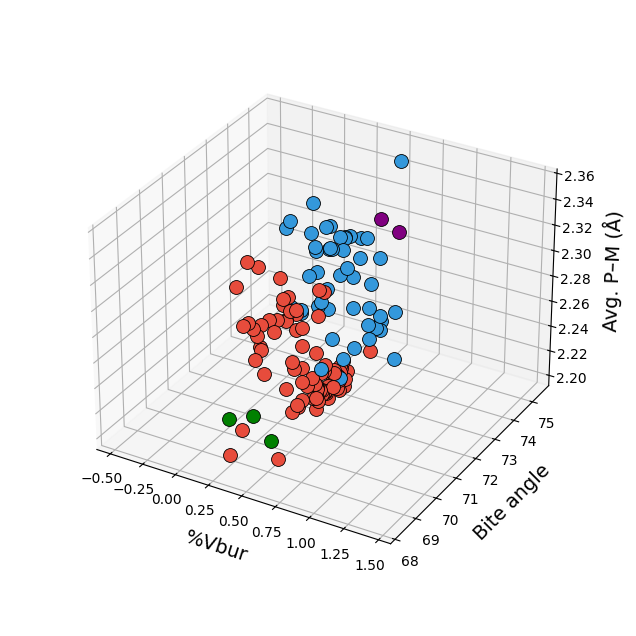

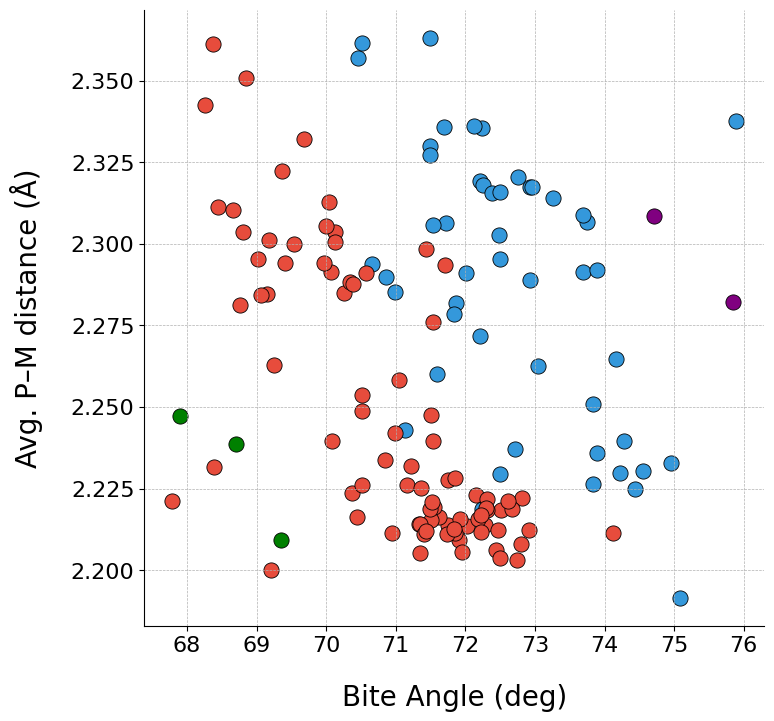

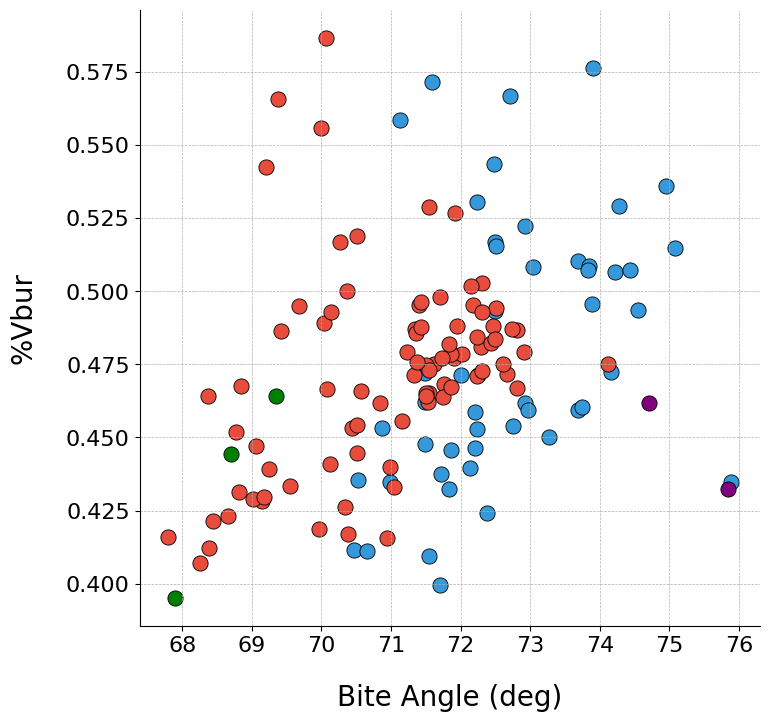

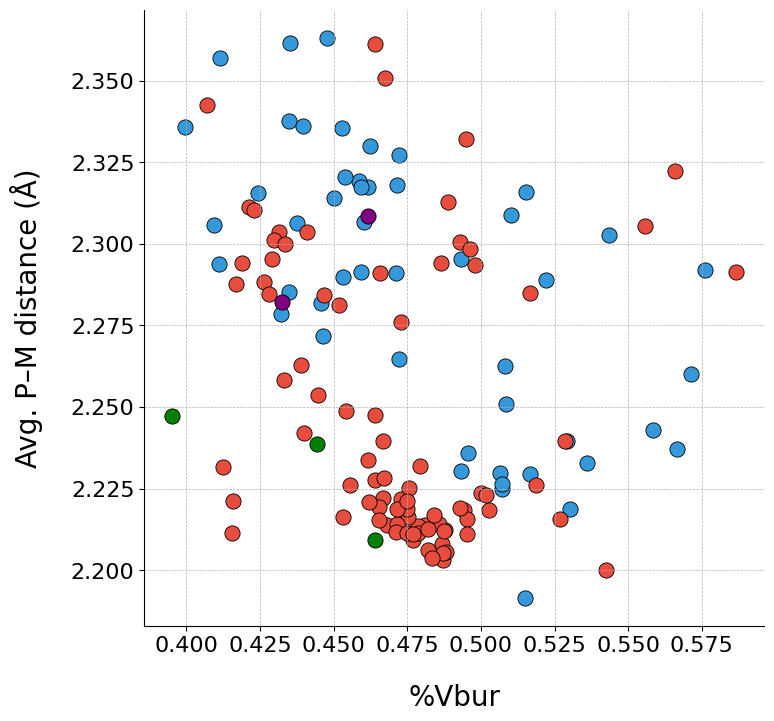

In [231]:
bridge_df = df[df["Type"].isin(['PCP', 'PNP', 'POP', 'PSP'])]
color_map = {
    'PCP': '#3498DB',
    'PNP': '#E74C3C',
    'POP': "green",
    "PSP": "purple"
}

fig = plt.figure(figsize=(10, 8), facecolor="white")

ax1 = fig.add_subplot(111, projection='3d')
create_3d_scatter(bridge_df, ax1, '%Vbur', 'Bite angle', 'Avg. P–M (Å)', '%Vbur', 'Bite angle', 'Avg. P–M (Å)', "Type", color_map)
ax1.set_box_aspect(None, zoom=0.85)
plt.show()

fig = plt.figure(figsize=(8, 8), facecolor="white")
ax2 = fig.add_subplot(111)
create_2d_scatter(bridge_df, ax2, 'Bite angle', 'Avg. P–M (Å)', 'Bite Angle (deg)', 'Avg. P–M distance (Å)', "Type", color_map)
plt.show()

fig = plt.figure(figsize=(8, 8), facecolor="white")
ax2 = fig.add_subplot(111)
create_2d_scatter(bridge_df, ax2, 'Bite angle', '%Vbur', 'Bite Angle (deg)', '%Vbur', "Type", color_map)
plt.show()

fig = plt.figure(figsize=(8, 8), facecolor="white")
ax2 = fig.add_subplot(111)
create_2d_scatter(bridge_df, ax2, '%Vbur', 'Avg. P–M (Å)', '%Vbur', 'Avg. P–M distance (Å)', "Type", color_map)
plt.show()